<a href="https://colab.research.google.com/github/jhermosillo/diplomado_CDD2019/blob/master/05%20Deep%20Learning/Notebooks/BackProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:50px;" align="left"> <img align="left" width="30%" src="img/cerebro_1.jpg"/>    
    Redes Neuronales Artificiales - Algoritmo BackPropagation

___

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import optimize
from scipy.io import loadmat

import scipy.optimize as opt
from sklearn import preprocessing

## Para subir carpetas a Colab

In [ ]:
# !apt-get install subversion
# !svn checkout "https://github.com/jhermosillo/diplomado_CDD2019/trunk/05%20Deep%20Learning/Data/"

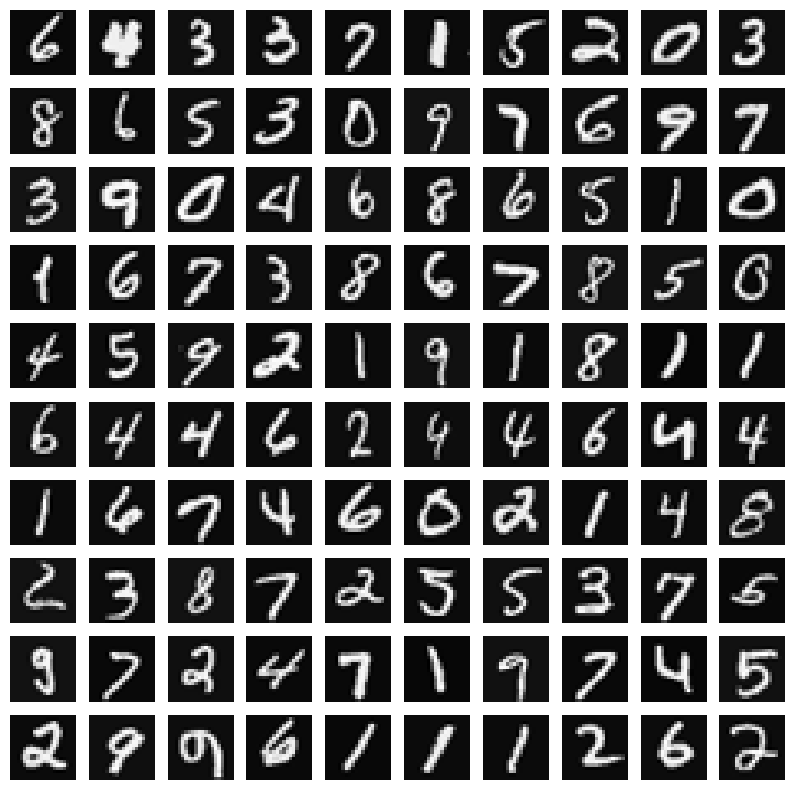

In [72]:
#  Datos de entrenamiento X, y
data = loadmat('Data/datosMNIST')
X, y = data['X'], data['y'].ravel()

# Estos datos fueron creados en MATLAB donde no hay índice 0
y[y == 10] = 0

# tamaño del conjunto de instancias
m = y.size

# indices de una permutación aleatoria de instancias 
# para visualizarlas
indices = np.random.permutation(m)

# Elegimos 100 puntos al azar para desplegar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :].reshape((10,10,-1))

# visualización de los datos
fig, axarr = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(sel[i,j].reshape((20,20), order = 'F'),cmap="gray")          
        axarr[i,j].axis('off')

### Parámetros para el ejercicio
* Al entrenar redes neuronales, es importante inicializar los parámetros con valores aleatorios para evitar simetrías. 
* Una estrategia efectiva es elegir valores iniciales aleatorios para  $\Theta^{(l)}$ unifórmemente distribuídos en el rango $[-\epsilon_{init},\epsilon_{init}]$. 
* Para elegir $\epsilon_{init}$ una forma efectiva es inicializarlo con base en el número de neuronas en la red. 
* Una buena elección de  $\epsilon_{init}$ es $$\epsilon_{init}=\frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$$ donde $L_{in}=s_l$ and $L_{out}=s_{l+1}$ son el número de neuronas en las capas adyacentes a $\Theta^{(l)}$. 
* Se sugiere usar $\epsilon_{init}=0.12$.

In [3]:
def randInitializeWeights(L_in, L_out):
    epsilon = 0.12
    return np.random.rand(L_out, L_in+1) * 2 * epsilon - epsilon

# Parámetros
neuronas_de_entrada  = 400  # Imágenes de entrada 20x20
neuronas_ocultas = 25   # 25 neuronas coultas
etiquetas = 10          # 10 etiquetas, clases de 0 a 9

Theta1 = randInitializeWeights(neuronas_de_entrada, neuronas_ocultas)
Theta2 = randInitializeWeights(neuronas_ocultas, etiquetas)

lmbda = 1
# desenrrollamos los parámetros para la función de optimización
rna_params = np.hstack((Theta1.ravel(order='F'), Theta2.ravel(order='F')))    #unroll parameters

In [4]:
print(Theta1.shape)
print(Theta2.shape)

(25, 401)
(10, 26)


## Modelo de red neuronal

La red neuronal que vamos a implementar es la siguiente:

<img align="left" width="50%" src="img/redneuronal.jpg"/> 

Tiene 3 capas: una capa de entrada, una capa oculta y una capa de salida. Recuerda que nuestras entradas son valores de pixeles de imágenes de dígitos. Dado que las imágenes tienen un tamaño de 20 × 20, esto nos da 400 neuronas de capa de entrada (excluyendo la neurona de polarización adicional que siempre genera +1). Como siempre, los datos de entrenamiento se cargarán en las variables $X$,$y$.

Se te ha proporcionado un conjunto de parámetros de la red ($\Theta^{(1)}$, $\Theta^{(2)}$) ya entrenados. Estos están almacenados en `pesosFW.mat`. La siguiente celda carga esos parámetros en `Theta1` y` Theta2`. Los parámetros tienen dimensiones para una red neuronal con 25 neuronas en la segunda capa y 10 neuronas de salida (correspondientes a las clases de 10 dígitos).

### Función de activación sigmoide

In [5]:
def sigmoide(z):
    return 1.0 / (1.0 + np.exp(-z))

___

## Función de Costo

* Primero implementaremos la función de costo seguida del gradiente para la red neuronal (para la que usaremos el algoritmo BackPropagation). 

* La función de costo con regularización L2 para nuestro problema es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} \left[ -y^{(i)}_k \log\left(\left(h_\theta\left( x^{(i)} \right)\right)_k \right) - \left( 1 - y^{(i)}_k\right) \log \left( 1 - \left(h_\theta\left( x^{(i)} \right)\right)_k \right) \right]+\frac{\lambda}{2m}\Big[\sum_{j=1}^{25} \sum_{k=1}^{400}(\Theta^{(1)}_{j,k})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25}(\Theta^{(2)}_{j,k})^2 \Big]$$

donde $K$ es el número total de etiquetas (10 en este caso), $\left(h_\theta\left( x^{(i)} \right)\right)_k = a^{(i)}_k$ es la activación de la neurona $k$ y $y^{(i)}_k$ es $1$ o $0$. 

* Recuerda que:

$$
\begin{align}
    y^{(i)} &= \begin{bmatrix}
           1 \\
           0 \\
           \vdots \\
           0
         \end{bmatrix},
         \begin{bmatrix}
           0 \\
           1 \\
           \vdots \\
           0
         \end{bmatrix}, \cdots,
         \begin{bmatrix}
           0 \\
           0 \\
           \vdots \\
           1
         \end{bmatrix}
\end{align}
$$


In [23]:
def rnaCosto(rna_params, entradas, ocultas, etiquetas, X, y, lmbda):
    theta1 = np.reshape(rna_params[:ocultas*(entradas+1)], (ocultas, entradas+1), 'F')
    theta2 = np.reshape(rna_params[ocultas*(entradas+1):], (etiquetas, ocultas+1), 'F')
    
    m = len(y)
    ones = np.ones((m,1))
    """Debes crear las siguientes variables correctamente"""
    a1 = 0
    a2 = 0
    h = 0
    """----------------TU CODIGO AQUI--------------"""
    features = preprocessing.PolynomialFeatures(1)
    a1 = features.fit_transform(X)              # X => N*(D+1)  | N es el número de instancias y D el número de dimensiones
    z2 = a1@Theta1.T                            # theta1 => 25*(D+1) z2 => N*25
    a2 = features.fit_transform(sigmoide(z2))   # Matriz de activación de la segunda capa, a2 => N*26
    z3 = a2@Theta2.T                            # theta2 => 10*26   z3 => N*10
    h = sigmoide(z3)                            # h => N*10 
    """--------------------------------------------"""
    
    y_d = pd.get_dummies(y.flatten())    
        
    temp1 = np.multiply(y_d, np.log(h))         # Multiplicación elemento por elemento (np.multiply)
    temp2 = np.multiply(1-y_d, np.log(1-h))     
    temp3 = np.sum(temp1 + temp2)               # Suma interna en el eje 0[default] (columnas)  
    
    sum1 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    sum2 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (sum1 + sum2) * lmbda / (2*m)

### Prueba el código
* Debe ser circa 7.0 (+/- 1)

In [24]:
J=rnaCosto(rna_params, neuronas_de_entrada, neuronas_ocultas, etiquetas, X, y, lmbda)
print('J=',J)

J= 6.725174154147658


## Función de Gradiente

* El gradiente de la función sigmoide es:

$$ g'(z)=\frac{d}{dz}g(z)=g(z)(1-g(z))$$

donde $$g(z) = \frac{1}{1+e^{-z}}$$

In [25]:
def sigmoidGrad(z):
    return np.multiply(sigmoide(z), 1-sigmoide(z))

## BackPropagation

* Recuerda que la intuición detrás del algoritmo de retropropagación es la siguiente. Dado un ejemplo de entrenamiento  
 $\big(x^{(t)},y^{(t)}\big)$  ejecutamos primero un "pase hacia adelante" para calcular todas las activaciones en la red, incluido el valor de salida del hipótesis $h_\Theta(x)$. Luego, para cada nodo $j$ en la capa $l$, nos gustaría calcular el "término de error" $\delta_j^{(l)}$ que mide cuánto ese nodo fue "responsable" de cualquier error en nuestra salida . 

* En resumen, hacemos lo siguiente recorriendo cada instancia de entrenamiento:
 0. Establece los valores de la capa de entrada $(a^{(1)})$ a la instancia de entrenamiento $i$-ésima $x^{(i)}$.
 1. Realiza una predición directa, calculando las activaciones $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$. Recuerda agregar un término $+1$ para incluir el sesgo en las capas 2 y 3.
 2. Calcula el término de error $\delta_k^{(3)} $ para cada unidad de salida como $\delta_k^{(3)} = (a_k^{(3)} - y_k)$, $y_k \in \{0,1\}$.
 3. Para la capa oculta $l = 2$, establece $$\delta^{(2)} = \big(\Theta^{((2)}\big)^T \delta^{(3) }.*g'\big(z^{(2)}\big)$$ donde $.* $ indica la multiplicación elemento a elemento.
 4. Acumula los gradientes usando $\Delta^{(l)} = \Delta^{(l)} + \delta^{(l + 1)} \big(a^{(l)}\big)^T$. Ten en cuenta que debes omitir $\delta_0^{(2)}$.
 5. Obtén los gradientes (no regularizados) para la función de costo de la red neuronal dividiendo los gradientes acumulados (del paso 4) entre m.
 6. Agrega los términos de regularización a los gradientes usando

$$
\begin{align}
    \frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) &= D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)} & \textrm{ for } j =0 \\
    \frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) &= D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)} + \frac{\lambda}{m}\Theta_{ij}^{(l)} & \textrm{ for } j \ge 1     
\end{align}
$$
* Ten en cuenta que no debes regularizar la primera columna de $\Theta^{(l)}$ que se usa para el término de sesgo.

In [73]:
def rnaGrad(rna_params, entradas, ocultas, etiquetas, X, y, lmbda):
    
    theta1_inicial = np.reshape(rna_params[:ocultas*(entradas+1)], (ocultas, entradas+1), 'F')
    theta2_inicial = np.reshape(rna_params[ocultas*(entradas+1):], (etiquetas, ocultas+1), 'F')
    
    #convert categorical classes into one-hot vectors data frame
    y_d = pd.get_dummies(y.flatten())   
    
    m = len(y)
    #inicialización de los errores de gradiente
    delta1 = np.zeros(theta1_inicial.shape)
    delta2 = np.zeros(theta2_inicial.shape)

    for i in range(X.shape[0]):
        ones = np.ones(1)
        """----------------TU CODIGO AQUI--------------"""
        # Forward propagation para la i-esima instancia
        a1 = np.hstack((ones,X[i]))                         # a1 => 1x(D+1)  donde D es la dimensión de los datos (en este caso 400)         
        z2 = a1@theta1_inicial.T                                    # z2 => 1x25  , theta1 => 25x(400+1)
        a2 = np.hstack((ones,sigmoide(z2)))                 # a2 => 1x(25+1)
        z3 = a2@theta2_inicial.T                                    # z3 => 1x10  , theta2 => 10x(25+1)
        a3 = sigmoide(z3)                                   # a3 => 1x10
        """--------------------------------------------"""
        #CODIGO para delta_3 y delta_2
        d3 = a3 - np.asarray(y_d.iloc[i,:])[np.newaxis,:]               # d3 => 1x10 
        z2 = np.hstack((ones, z2))                          # z2 => 1x(25+1)
        d2 = np.multiply(theta2_inicial.T @ d3.T, sigmoidGrad(z2).T[:,np.newaxis]) # theta2_inicial.T@d3.T => 26x1 , sigmoidGrad(z2).T[:,np.newaxis] => (25+1)x1
        # d2 => 26x1

        """Debes actualizar las siguientes variables correctamente"""
        """----------------TU CODIGO AQUI--------------"""
        delta1 += d2[1:,:] @ a1[np.newaxis,:]               # delta1 => 25x401
        delta2 += d3.T @ a2[np.newaxis,:]                   # delta2 => 10x26
        """--------------------------------------------"""
        
    delta1 /= m
    delta2 /= m
    #print(delta1.shape, delta2.shape)
    delta1[:,1:] = delta1[:,1:] + theta1_inicial[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + theta2_inicial[:,1:] * lmbda / m
        
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))

In [75]:
rna_backprop_Params = rnaGrad(rna_params, neuronas_de_entrada, neuronas_ocultas, etiquetas, X, y, lmbda)

In [76]:
def checaGradiente(rna_initial_params,rna_backprop_Params,entradas, ocultas, etiquetas,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = rna_initial_params
    flattenedDs = rna_backprop_Params
    n_elems = len(flattened) 
    #Toma 10 elementos aleatorios, calcula el gradiente numérico, comprara contra las respectivas D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = rnaCosto(flattened + epsvec.flatten(),entradas, ocultas, etiquetas,myX,myy,mylambda)
        cost_low  = rnaCosto(flattened - epsvec.flatten(),entradas, ocultas, etiquetas,myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Elemento: {0}. Gradiente Numérico = {1:.9f}. Gradiente BackProp  = {2:.9f}.".format(x,mygrad,flattenedDs[x]))

In [77]:
checaGradiente(rna_params,rna_backprop_Params,neuronas_de_entrada, neuronas_ocultas, etiquetas,X,y,lmbda)

Elemento: 6532. Gradiente Numérico = -0.000008661. Gradiente BackProp  = 0.000005711.
Elemento: 8909. Gradiente Numérico = -0.000016173. Gradiente BackProp  = -0.000187289.
Elemento: 3489. Gradiente Numérico = 0.000008858. Gradiente BackProp  = -0.000674221.
Elemento: 4123. Gradiente Numérico = 0.000017402. Gradiente BackProp  = -0.001140185.
Elemento: 5184. Gradiente Numérico = 0.000006038. Gradiente BackProp  = -0.003375282.
Elemento: 2128. Gradiente Numérico = -0.000012704. Gradiente BackProp  = -0.000603725.
Elemento: 4487. Gradiente Numérico = 0.000006935. Gradiente BackProp  = -0.000535302.
Elemento: 4099. Gradiente Numérico = 0.000009933. Gradiente BackProp  = 0.000196771.
Elemento: 686. Gradiente Numérico = -0.000009581. Gradiente BackProp  = -0.000011239.
Elemento: 5473. Gradiente Numérico = 0.000006143. Gradiente BackProp  = -0.001312686.


In [78]:
theta_opt = opt.fmin_cg(maxiter = 50, f = rnaCosto, x0 = rna_params, fprime = rnaGrad, \
                        args = (neuronas_de_entrada, neuronas_ocultas, etiquetas, X, y.flatten(), lmbda))

theta1_opt = np.reshape(theta_opt[:neuronas_ocultas*(neuronas_de_entrada+1)], (neuronas_ocultas, neuronas_de_entrada+1), 'F')
theta2_opt = np.reshape(theta_opt[neuronas_ocultas*(neuronas_de_entrada+1):], (etiquetas, neuronas_ocultas+1), 'F')

         Current function value: 6.725174
         Iterations: 0
         Function evaluations: 71
         Gradient evaluations: 59


In [79]:
def predict(theta1, theta2, X, y):
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoide(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoide(a2 @ theta2.T)
    return np.argmax(h, axis = 1)

In [80]:
pred = predict(theta1_opt, theta2_opt, X, y)
print('Exactitud: ',np.mean(pred == y.flatten()) * 100,'%')

Exactitud:  10.02 %
